In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [4]:
os.getcwd()

'/content/drive/MyDrive/Alibi-detect'

In [3]:
os.chdir("drive/MyDrive/Alibi-detect")

In [5]:
!pip install alibi-detect[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.8/380.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-

In [6]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [7]:
image_directory = "data"
SIZE = 64
dataset = []

In [8]:
good_images = os.listdir(os.path.join(image_directory, "good"))
for i, image_name in enumerate(good_images):
  image_path = os.path.join(image_directory, "good", image_name)
  image = cv2.imread(image_path)
  image = Image.fromarray(image, 'RGB')
  image = image.resize((SIZE, SIZE))
  dataset.append(np.array(image))

In [9]:
len(dataset)

280

In [10]:
dataset = np.array(dataset)

In [11]:
train = dataset[0:200]
test = dataset[200:279]

In [12]:
train = train.astype("float32")/ 255
test = test.astype("float32") / 255

In [13]:
bad_dataset = []
bad_images = os.listdir(os.path.join(image_directory, "bad"))
for i, image_name in enumerate(bad_images):
  image_path = os.path.join(image_directory, "bad", image_name)
  image = cv2.imread(image_path)
  image = Image.fromarray(image, 'RGB')
  image = image.resize((SIZE, SIZE))
  bad_dataset.append(np.array(image))

In [14]:
len(bad_dataset)

89

In [15]:
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype("float32") / 255

In [16]:
bottleneck_dim = 1024
dense_dim =[8, 8, 512]

In [17]:
encoder = tf.keras.Sequential(
    [
        InputLayer(input_shape=train[0].shape),
        Conv2D(64, 4, strides=2, padding="same", activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding="same", activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding="same", activation=tf.nn.relu),
        Flatten(),
        Dense(bottleneck_dim,)
    ]
)

In [18]:
print(encoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34738880 (132.52 MB)
Trainable params: 34738880 (132.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
decoder = tf.keras.Sequential(
    [
        InputLayer(input_shape=(bottleneck_dim,)),
        Dense(np.prod(dense_dim)),
        Reshape(target_shape=dense_dim),
        Conv2DTranspose(256, 4, strides=2, padding="same", activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding="same", activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding="same", activation='sigmoid'),
        ]
)

In [20]:
print(decoder.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 64)        262208    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 3)         3075      
 Transpose)                                                      
                                                      

In [21]:
od = OutlierVAE(
    threshold=.015,
    score_type="mse",
    encoder_net=encoder,
    decoder_net=decoder,
    latent_dim=bottleneck_dim,
    samples=4
)

In [22]:
print("Current threshold is:  ", od.threshold)

Current threshold is:   0.015


In [23]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [24]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
alibi-detect==0.11.5
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.0.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.1
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.5
cufflinks==0.17.3

In [25]:
od.fit(train,
       optimizer=adam,
       epochs=20,
       batch_size=4,
       verbose=True)

 3/50 [.] - ETA: 2:06 - loss_ma: 30341.1778

KeyboardInterrupt: 

In [27]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [29]:
!alibi_detect --version

/bin/bash: line 1: alibi_detect: command not found


In [ ]:
od.infer_threshold(test, outlier_type="instance", threshold_perc=99.0)
print("Current threshold is: ", od.threshold)

Current threshold is:  0.004511050162836909


In [ ]:
!pip install typing-extensions==4.5.0

In [ ]:
from alibi_detect.saving import save_detector, load_detector
# save_detector(od, "saved_models/carpet_od_5.h5")

In [ ]:
od = load_detector("saved_models/carpet_od_5.h5")

/usr/local/lib/python3.10/dist-packages/alibi_detect/saving/_tensorflow/loading.py:222: UserWarning: Trying to load detector from version 0.11.4 when using version 0.11.5. This may lead to breaking code or invalid results.
  warnings.warn(f'Trying to load detector from version {meta_dict["version"]} when using version '


In [ ]:
od.threshold = 0.002

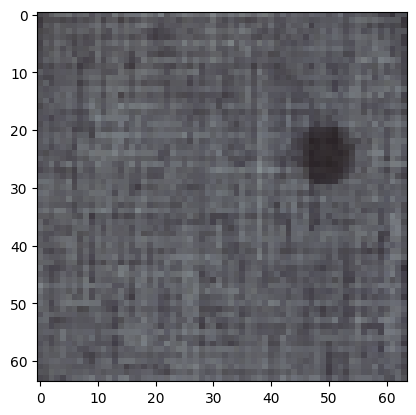

In [ ]:
img_num = 1
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

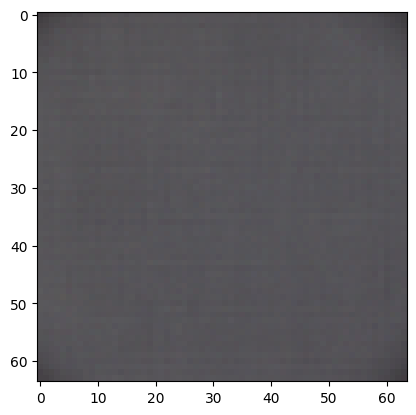

In [ ]:
test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

In [ ]:
test_bad_image_predict = od.predict(test_bad_image)

In [ ]:
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]

In [ ]:
print("The instance score is ", bad_image_instance_score)

The instance score is  0.0014957812


In [ ]:
od.threshold

0.002

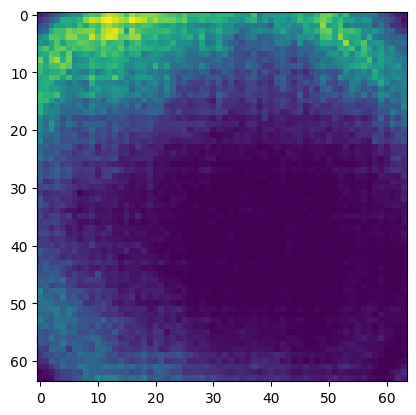

In [ ]:
bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])

In [ ]:
test_bad_image_predict['data']['is_outlier'][0]

0

In [ ]:
len(bad_dataset)

33

In [ ]:
od.threshold = 0.0015

In [ ]:
X = bad_dataset[0:10]
od_preds = od.predict(X, outlier_type="instance", return_feature_score=True, return_instance_score=True)

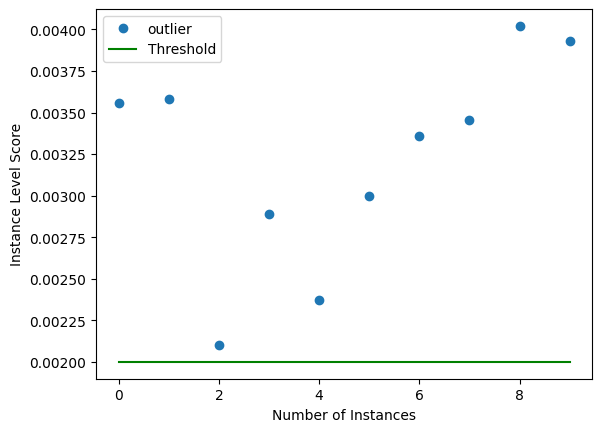

In [ ]:
target = np.ones(X.shape[0],).astype(int)
labels = ["normal", "outlier"]
plot_instance_score(od_preds, target, labels, od.threshold)

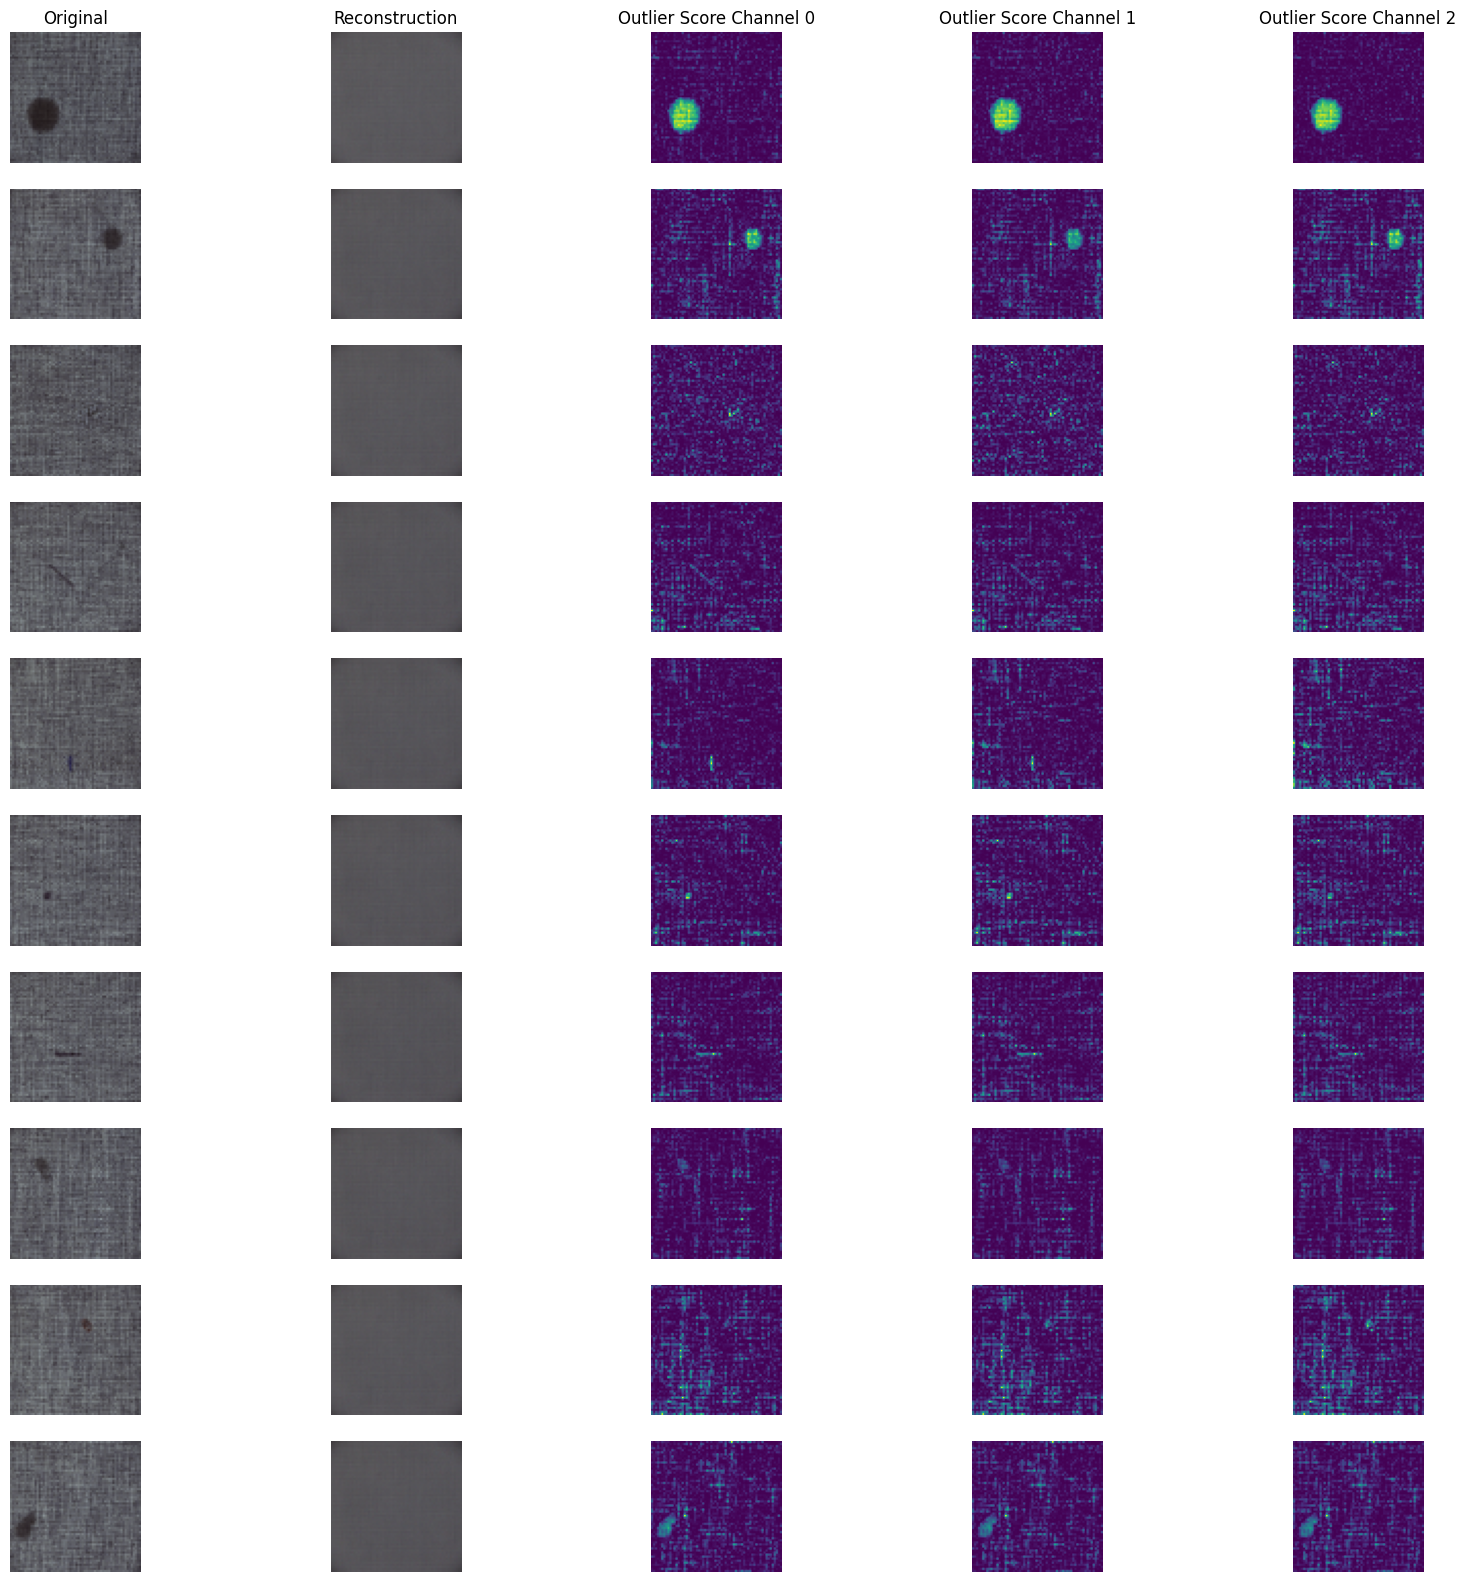

In [ ]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           max_instances=10,
                           outliers_only=False)


In [ ]:
len(predictions)

32

In [ ]:
predictions = od_preds["data"]["feature_score"]

In [ ]:
predictions[0][:, :, 2]

array([[4.48880281e-04, 4.31569293e-04, 2.17735404e-04, ...,
        2.26611970e-03, 3.19065817e-04, 1.88019243e-04],
       [2.73237121e-03, 4.39826399e-04, 1.63046643e-03, ...,
        4.60420561e-05, 5.29718876e-04, 1.03148624e-04],
       [3.55169395e-05, 7.84248987e-04, 5.06445393e-03, ...,
        4.28685562e-05, 2.89499876e-05, 3.11568961e-04],
       ...,
       [4.07499145e-04, 1.55527378e-03, 2.14765096e-04, ...,
        8.19841959e-03, 3.84984305e-03, 2.28986726e-03],
       [2.35084444e-03, 3.84955062e-03, 1.09356781e-03, ...,
        3.05085705e-04, 6.47862398e-05, 6.45689317e-04],
       [1.06960928e-04, 6.86046318e-04, 1.05721469e-03, ...,
        5.47215641e-05, 1.50413442e-04, 1.10799599e-04]], dtype=float32)

In [ ]:
count = 0
for feature_score in predictions:
  print(feature_score.shape)
  # print(type(feature_score))
  pil_image = Image.fromarray(feature_score[:, :, 0])
  pil_image_resized = pil_image.resize((600,600))
  plt.imsave(os.path.join("data/real_data_output", f"{count}_map.jpeg"), pil_image_resized)
  count = count + 1
  # plt.imshow(feature_score[:, :, 2])

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


In [ ]:
type(X[0])

numpy.ndarray

In [ ]:
count = 0
for image in X:
  image = image * 255
  image = image.astype(np.uint8)
  image = Image.fromarray(image)
  image = image.resize((600,600))
  plt.imsave(os.path.join("data/bad_output", f"{count}.jpeg"), image)

In [ ]:
bad_dataset = []
bad_images = os.listdir(os.path.join(image_directory, "bad"))
for i, image_name in enumerate(bad_images):
  image_path = os.path.join(image_directory, "bad", image_name)
  image = cv2.imread(image_path)
  image = Image.fromarray(image, 'RGB')
  image = image.resize((SIZE, SIZE))
  bad_dataset.append(np.array(image))

In [ ]:
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype("float32") / 255

In [ ]:
from alibi_detect.saving import save_detector, load_detector
od = load_detector("saved_models/carpet_od_5.h5")

In [ ]:
X = bad_dataset[0:10]
od_preds = od.predict(X, outlier_type="instance", return_feature_score=True, return_instance_score=True)

In [ ]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           max_instances=10,
                           outliers_only=False)
